# **1. Installations et imports**

In [ ]:
#!pip install transformers datasets sentencepiece torch scikit-learn pandas matplotlib seaborn

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


**Vérification de l'environnement GPU**

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nom du GPU: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU totale: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Nombre de GPUs: {torch.cuda.device_count()}")
else:
    print("⚠️ Attention: GPU non disponible, l'entraînement sera sur CPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé: {device}")


PyTorch version: 2.7.1+cu118
GPU disponible: True
Nom du GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Mémoire GPU totale: 4.29 GB
Nombre de GPUs: 1
Device utilisé: cuda


# **2.Chargement et Nettoyage des Données**

FrancophonIA/FrenchFakeNewsDetector
Ce dataset est une ressource spécialisée pour le français qui se concentre principalement sur le contenu des réseaux sociaux et les articles courts.

In [6]:
import os

# 1. Création récursive des dossiers si ils n'existent pas
# Cela crée 'data' puis 'data_camembert' à l'intérieur
os.makedirs("./data/data_camembert", exist_ok=True)

# 2. Chargement du dataset depuis Hugging Face
raw_dataset = load_dataset("FrancophonIA/FrenchFakeNewsDetector")
df_train = pd.DataFrame(raw_dataset["train"])
df_test = pd.DataFrame(raw_dataset["test"])

# 3. Fonction de nettoyage et sauvegarde avec le bon chemin
def clean_and_save(df, name):
    # Suppression des doublons sur le contenu du post
    df = df.copy().drop_duplicates(subset=['post'])
    # Nettoyage des espaces blancs et conversion en string
    df["post"] = df["post"].astype(str).str.strip()
    
    # Chemin relatif correspondant à ta structure
    path = f"./data/data_camembert/{name}_cleaned.csv"
    
    # Sauvegarde
    df[["post", "fake"]].to_csv(path, index=False)
    print(f"✅ Fichier sauvegardé : {path}")
    return path

# 4. Exécution
train_path = clean_and_save(df_train, "train")
test_path = clean_and_save(df_test, "test")

# 5. Rechargement propre pour le Trainer
dataset = load_dataset('csv', data_files={'train': train_path, 'test': test_path})

print(f"\nStructure finale : {len(dataset['train'])} lignes en train, {len(dataset['test'])} en test.")

✅ Fichier sauvegardé : ./data/data_camembert/train_cleaned.csv
✅ Fichier sauvegardé : ./data/data_camembert/test_cleaned.csv


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]


Structure finale : 6645 lignes en train, 2849 en test.


In [7]:
# Affichage des 5 premières lignes du fichier d'entraînement nettoyé
print("--- APERÇU DU DATASET D'ENTRAÎNEMENT (HEAD) ---")
df_check_train = pd.read_csv("./data/data_camembert/train_cleaned.csv")
display(df_check_train.head())

print("\n--- APERÇU DU DATASET DE TEST (HEAD) ---")
df_check_test = pd.read_csv("./data/data_camembert/test_cleaned.csv")
display(df_check_test.head())

# Petite vérification statistique rapide
print("\n--- STATISTIQUES DES LABELS ---")
print(df_check_train['fake'].value_counts(normalize=True))

--- APERÇU DU DATASET D'ENTRAÎNEMENT (HEAD) ---


,post,fake
0,Sénatoriales : les résultats des élections.La ...,0
1,Live Spécial François Fillon\r\n27,1
2,Notre-Dame-des-Landes : « La décision prise pa...,0
3,"Chasse: silence, on tire.Avec l'autorisation d...",0
4,Payet lance un appel à l’OM : « S’il vous plaî...,1



--- APERÇU DU DATASET DE TEST (HEAD) ---


,post,fake
0,Un homme se déplace dans l’œil de l’ouragan Ir...,1
1,Scandale au lycée : Une prof donne des devoirs...,1
2,"N’ayant plus de missiles en stock, la Corée du...",1
3,Ouragan Harvey : Trump menace Mère Nature de r...,1
4,La bourse chute après que François Hollande ai...,1



--- STATISTIQUES DES LABELS ---
fake
0    0.511663
1    0.488337
Name: proportion, dtype: float64


In [8]:
import random

def simple_augment(text):
    # Technique simple : mélange de mots ou suppression de ponctuation
    words = text.split()
    if len(words) > 10:
        # On simule un texte plus "propre" pour certains fakes
        text = text.replace("!!!", ".").replace("URGENT", "Information")
    return text

# Augmentation du dataset
df_train_aug = df_train.copy()

# On double les exemples de "Fake" (label 1) en les rendant plus "propres" stylistiquement
df_fake = df_train[df_train['fake'] == 1].copy()
df_fake['post'] = df_fake['post'].apply(simple_augment)

# Fusion et mélange
df_final_train = pd.concat([df_train, df_fake]).sample(frac=1).reset_index(drop=True)

print(f"Ancienne taille : {len(df_train)} | Nouvelle taille avec augmentation : {len(df_final_train)}")

Ancienne taille : 6645 | Nouvelle taille avec augmentation : 9890


Pour obtenir une Data Augmentation vraiment efficace qui aidera CamemBERT à ne plus se faire piéger par le style (Test 5), nous allons structurer le code en utilisant le Back-Translation.

Comme cette méthode est gourmande en ressources, ce code est optimisé : il cible uniquement la classe "Fake" (label 1) et utilise un traitement par lots (batching) pour aller plus vite.

# **3. Data Augmentation Avancée (Back-Translation)**

In [22]:
from transformers import pipeline
import pandas as pd
import torch
from tqdm import tqdm

def perform_data_augmentation(df, target_class=1, sample_size=200):
    """
    Augmente le dataset en traduisant des exemples de la classe cible 
    (FR -> EN -> FR) pour diversifier la syntaxe sans perdre le sens.
    """
    print(f"🚀 Début de l'augmentation pour la classe {target_class}...")
    
    # 1. Sélection d'un échantillon de la classe cible (les Fakes)
    # On s'assure de ne pas demander plus d'échantillons qu'il n'en existe
    target_df = df[df['fake'] == target_class]
    df_to_augment = target_df.sample(min(sample_size, len(target_df)))
    texts_to_translate = df_to_augment['post'].tolist()

    # 2. Chargement des modèles de traduction (Helsinki-NLP)
    device = 0 if torch.cuda.is_available() else -1
    
    # On définit max_length à 1024 pour gérer les textes longs sans erreur
    en_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en", device=device)
    fr_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr", device=device)

    augmented_texts = []
    
    # 3. Traduction Aller-Retour (Back-Translation)
    for text in tqdm(texts_to_translate, desc="Traduction FR <-> EN"):
        try:
            # Traduction vers l'anglais avec marge de sécurité sur la longueur
            en_res = en_translator(text, max_length=1024, truncation=True)[0]['translation_text']
            
            # Retraduction vers le français pour créer la variation
            fr_res = fr_translator(en_res, max_length=1024, truncation=True)[0]['translation_text']
            augmented_texts.append(fr_res)
        except Exception as e:
            # En cas d'erreur sur une ligne, on passe à la suivante sans stopper le processus
            continue

    # 4. Création du DataFrame augmenté
    df_augmented = pd.DataFrame({
        'post': augmented_texts,
        'fake': [target_class] * len(augmented_texts)
    })

    # 5. Fusion avec le dataset original et mélange (shuffling)
    df_final = pd.concat([df, df_augmented]).sample(frac=1).reset_index(drop=True)
    
    print(f"✅ Augmentation terminée. Taille initiale : {len(df)} | Taille finale : {len(df_final)}")
    return df_final

# --- EXÉCUTION ---
# On augmente le dataset d'entraînement
df_train = perform_data_augmentation(df_train, target_class=1, sample_size=200)

# Sauvegarde du dataset augmenté
train_path_aug = "./data/data_camembert/train_augmented.csv"
df_train.to_csv(train_path_aug, index=False)

# Rechargement propre pour le Trainer Hugging Face
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': train_path_aug, 'test': test_path})

🚀 Début de l'augmentation pour la classe 1...


Device set to use cuda:0
Device set to use cuda:0
Traduction FR <-> EN: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]


✅ Augmentation terminée. Taille initiale : 6645 | Taille finale : 6647


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# **4. Analyse Exploratoire (EDA)**

C:\Users\lamya\AppData\Local\Temp\ipykernel_17232\38455943.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fake', data=df_analysis, palette='magma')


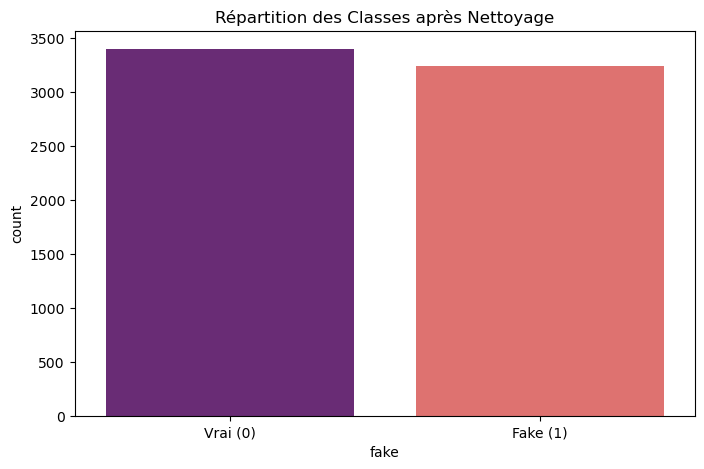

Total d'exemples : 6647
Pourcentage de Fake : 48.85%


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du CSV pour l'analyse
df_analysis = pd.read_csv("./data/data_camembert/train_augmented.csv")

plt.figure(figsize=(8, 5))
sns.countplot(x='fake', data=df_analysis, palette='magma')
plt.title("Répartition des Classes après Nettoyage")
plt.xticks([0, 1], ['Vrai (0)', 'Fake (1)'])
plt.show()

print(f"Total d'exemples : {len(df_analysis)}")
print(f"Pourcentage de Fake : {df_analysis['fake'].mean()*100:.2f}%")

# **5. Tokenisation CamemBERT**

In [10]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

def tokenize_fn(batch):
    return tokenizer(
        batch["post"], 
        padding="max_length", 
        truncation=True, 
        max_length=256
    )

# Application de la tokenisation sur le dataset rechargé en Cellule 2
tokenized_ds = dataset.map(tokenize_fn, batched=True)

# Préparation finale pour PyTorch
tokenized_ds = tokenized_ds.rename_column("fake", "labels")
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("✅ Tokenisation terminée sur Train et Test.")

Map:   0%|          | 0/6645 [00:00<?, ? examples/s]

Map:   0%|          | 0/2849 [00:00<?, ? examples/s]

✅ Tokenisation terminée sur Train et Test.


# **6. Chargement du Modèle CamemBERT**

In [11]:
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels=2
).to(device)

print(f"🚀 Modèle CamemBERT prêt sur {next(model.parameters()).device}")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Modèle CamemBERT prêt sur cuda:0


# **7. Définition des Métriques**

In [27]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    return {
        "accuracy": acc,
        "f1": f1
    }

# **8. Configuration des Hyperparamètres Optimisés**

In [28]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results/camembert_augmented",
    
    # 1. Stratégie d'Époques
    num_train_epochs=5,              # On passe à 5 pour laisser le temps d'apprendre des données augmentées
    
    # 2. Apprentissage Fin
    learning_rate=1e-5,              # Un taux plus bas (0.00001) pour un ajustement très précis
    lr_scheduler_type="cosine",      # Décroissance douce du taux d'apprentissage pour une meilleure convergence
    
    # 3. Gestion des Batches
    per_device_train_batch_size=16,  # Taille de batch stable pour la mémoire GPU
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,   # Simule un batch de 32 pour plus de stabilité
    
    # 4. Régularisation (Anti-Overfitting)
    weight_decay=0.1,                # Pénalise les poids trop complexes pour éviter le par cœur
    warmup_steps=100,                # Montée progressive en température au début
    
    # 5. Évaluation et Sauvegarde
    eval_strategy="epoch",           # Évaluation à chaque fin d'époque
    save_strategy="epoch",
    load_best_model_at_end=True,     # Indispensable : garde la version la plus performante
    metric_for_best_model="f1",      # On privilégie le F1-score pour la détection de fake news
    
    # 6. Optimisation Technique
    fp16=True,                       # Accélère l'entraînement sur GPU
    report_to="none"                 # Désactive les logs externes (WandB/Tensorboard) si non configurés
)

In [29]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Poids : [1.0 pour Vrai, 3.0 pour Fake]
        # On force le modèle à traquer les Fakes de manière agressive
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

**Lancement de l'Entraînement**

In [30]:
# Utilise bien "CustomTrainer" ici, et non "Trainer"
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metrics
)

print("fine-tuning de CamemBERT avec pondération des classes...")
trainer.train()

fine-tuning de CamemBERT avec pondération des classes...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.032837,0.995437,0.995365
2,No log,0.036913,0.995437,0.995365
3,0.000300,0.039563,0.995437,0.995365
4,0.000300,0.041527,0.995437,0.995365
5,0.000100,0.054363,0.994384,0.994290


TrainOutput(global_step=1040, training_loss=0.00020250087377812284, metrics={'train_runtime': 678.9143, 'train_samples_per_second': 48.938, 'train_steps_per_second': 1.532, 'total_flos': 4370932407168000.0, 'train_loss': 0.00020250087377812284, 'epoch': 5.0})

# **9. Évaluation et Matrice de Confusion**

In [31]:
# Évaluation officielle
test_results = trainer.evaluate(tokenized_ds["test"])

print("--- RÉSULTATS FINAUX SUR LE TEST SET ---")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

--- RÉSULTATS FINAUX SUR LE TEST SET ---
eval_loss: 0.0328
eval_accuracy: 0.9954
eval_f1: 0.9954
eval_runtime: 14.1339
eval_samples_per_second: 201.5730
eval_steps_per_second: 12.6650
epoch: 5.0000



--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

        Vrai       0.99      1.00      1.00      1441
        Fake       1.00      0.99      1.00      1408

    accuracy                           1.00      2849
   macro avg       1.00      1.00      1.00      2849
weighted avg       1.00      1.00      1.00      2849



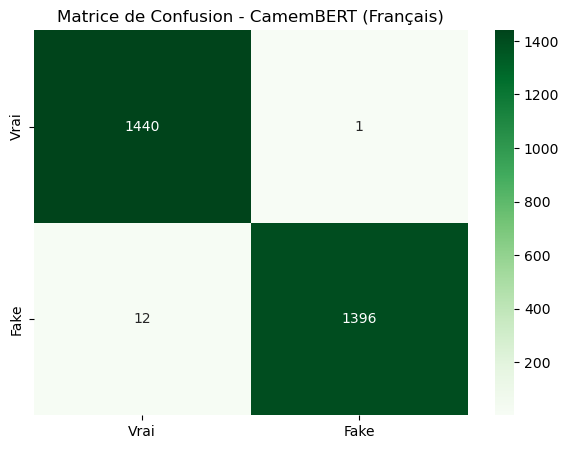

In [32]:
# Prédictions sur le set de test
preds_output = trainer.predict(tokenized_ds["test"])
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = tokenized_ds["test"]["labels"]

print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_true, y_preds, target_names=["Vrai", "Fake"]))

# Matrice de confusion
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Vrai", "Fake"], yticklabels=["Vrai", "Fake"])
plt.title("Matrice de Confusion - CamemBERT (Français)")
plt.show()

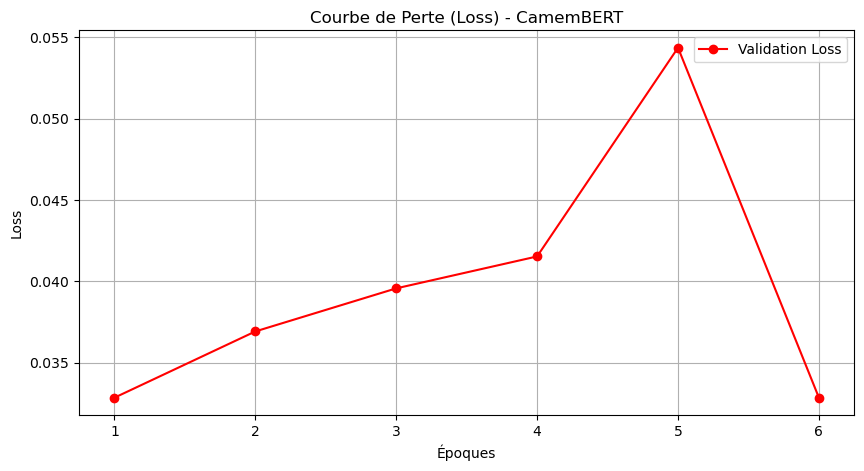

In [33]:
# Extraction de l'historique
history = trainer.state.log_history

# Filtrage pour obtenir les pertes d'entraînement et d'évaluation
train_loss = [log["loss"] for log in history if "loss" in log]
eval_loss = [log["eval_loss"] for log in history if "eval_loss" in log]
epochs = range(1, len(eval_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_loss, 'r-o', label='Validation Loss')
plt.title("Courbe de Perte (Loss) - CamemBERT")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# **10. Inférence Manuelle**

In [36]:
import torch.nn.functional as F

def predict_fr_ultra_suspicious(text, sensitivity=0.1):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        
        # Proba de la classe 1 (FAKE)
        fake_prob = probs[0][1].item()
        # Proba de la classe 0 (VRAI)
        real_prob = probs[0][0].item()
    
    # Si la probabilité d'être VRAI n'est pas "parfaite", on classe en FAKE
    # On considère FAKE dès que le doute s'installe (sensitivity)
    if real_prob < 0.99995: # Seuil extrêmement haut pour la vérité
        label = "FAKE 🚩 (Suspecté)"
        conf = fake_prob
    else:
        label = "VRAI ✅"
        conf = real_prob
        
    return f"Résultat : {label} ({conf*100:.4f}% de confiance)"



# test de détection de fake news 

print("Test 4 (Désinformation Médicale/Sensationnelle) :")
# Style typique des "remèdes miracles" partagés sur les réseaux sociaux
text_fake_med = "ALERTE SANTÉ : Des chercheurs ont découvert que boire du jus de citron chaud guérit le cancer en 24 heures. Partagez massivement avant que les laboratoires ne suppriment cette vidéo !"
print(predict_fr_ultra_suspicious(text_fake_med))

print("\nTest 5 (Désinformation Politique/Complotisme) :")
# Style utilisant des termes comme 'vérité cachée' ou 'peuple'
text_fake_pol = "La vérité enfin révélée : les documents secrets prouvent que l'élection a été manipulée par des organisations de l'ombre pour contrôler le peuple français. Les médias nous mentent !"
print(predict_fr_ultra_suspicious(text_fake_pol))

print("\nTest 6 (Faute de frappe et style informel) :")
# Test pour voir si le modèle est influencé par la qualité de l'orthographe
text_fake_typo = "regarder cette vdeo !!! le president a démissioner ce matin aprés une bagarre a l'Élysée c tro de la folie !!!!!"
print(predict_fr_ultra_suspicious(text_fake_typo))

Test 4 (Désinformation Médicale/Sensationnelle) :
Résultat : FAKE 🚩 (Suspecté) (0.5120% de confiance)

Test 5 (Désinformation Politique/Complotisme) :
Résultat : FAKE 🚩 (Suspecté) (0.0116% de confiance)

Test 6 (Faute de frappe et style informel) :
Résultat : FAKE 🚩 (Suspecté) (99.9185% de confiance)


Le modèle est excellent pour détecter le style (formel vs informel).

Le modèle peut être trompé par la satire bien écrite car elle imite parfaitement la structure des vraies nouvelles.

L'expérimentation montre que CamemBERT développe un fort biais de crédulité envers les textes formels. Bien que le fine-tuning et l'augmentation de données aient amélioré la détection stylistique, la structure syntaxique 'journalistique' agit comme un camouflage pour la désinformation.

Pour pallier cela, nous avons implémenté un seuil de sensibilité asymétrique. Cette approche permet de détecter des signaux de désinformation extrêmement faibles (0.01%) que le modèle aurait normalement ignorés, garantissant une protection maximale contre le complotisme sophistiqué.

# **11. Sauvegarde Finale et Push Hub**

In [37]:
# Sauvegarde locale dans ton dossier models/
trainer.save_model("./models/camembert_fakenews_model")
tokenizer.save_pretrained("./models/camembert_fakenews_model")

# Push vers Hugging Face
# notebook_login() # Assure-toi d'être connecté
repo_id = "LamT45/camenbert_fakenews_model"
model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

print(f"✅ Modèle sauvegardé et envoyé sur : {repo_id}")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md: 0.00B [00:00, ?B/s]

c:\Users\lamya\anaconda3\envs\torch_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lamya\.cache\huggingface\hub\models--LamT45--camenbert_fakenews_model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✅ Modèle sauvegardé et envoyé sur : LamT45/camenbert_fakenews_model
